#### ==============================================================================
## STEP 1: SETUP AND INSTALLATIONS
#### ==============================================================================
##### We begin by installing all necessary libraries. This includes Unsloth for
##### efficient model loading, Ragas for evaluation, and all the required
##### components for our retrievers and the OpenAI judge LLM.

In [ ]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" -q
!pip install --no-deps xformers trl peft accelerate bitsandbytes -q
!pip install -qU ragas langchain-openai langchain-community fastembed langchain-chroma langchain-core chromadb rank_bm25 sentence-transformers datasets pandas

print("✅ All libraries installed successfully.")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.8.9 requires datasets<4.0.0,>=3.4.1, but you have datasets 4.0.0 which is incompatible.
✅ All libraries installed successfully.


#### ==============================================================================
## STEP 2: API CONFIGURATION AND IMPORTS
#### ==============================================================================
#### Here, we'll import our libraries and configure API keys from Colab Secrets.
####
#### INSTRUCTIONS:
#### 1. Go to the "Secrets" tab (key icon) in your Colab notebook.
#### 2. Add a secret named 'OpenRouter_API' with your OpenRouter API key.
#### 3. Add a secret named 'HUGGING_FACE_TOKEN' with your Hugging Face token
####    (this is good practice for downloading models like Phi-3).

In [ ]:
import os
import pickle
import torch
import pandas as pd
from tqdm import tqdm
from google.colab import userdata
from datasets import Dataset

# Unsloth for efficient model loading
from unsloth import FastLanguageModel

# RAG components
from langchain_community.embeddings import FastEmbedEmbeddings
from langchain_chroma import Chroma
from sentence_transformers import CrossEncoder

# Ragas and LangChain components for evaluation
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    faithfulness,
    answer_correctness,
    answer_relevancy,
    context_recall
)
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


    PyTorch 2.8.0+cu128 with CUDA 1208 (you have 2.7.1+cu128)
    Python  3.9.23 (you have 3.10.10)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
print("Imports complete. Configuring API keys...")

# --- Configure API Keys ---
try:
    # Set up OpenRouter API key for the Ragas Judge LLM
    OPENROUTER_API_KEY = userdata.get('OpenRouter_API')
    os.environ["OPENAI_API_KEY"] = OPENROUTER_API_KEY
    os.environ["OPENAI_API_BASE"] = "https://openrouter.ai/api/v1"

    # Set up Hugging Face token for model downloading
    HF_TOKEN = userdata.get('hugging')
    print("✅ API keys configured successfully.")
except Exception as e:
    print("🚨 ERROR: Could not find secrets. Please add 'OpenRouter_API' and 'HUGGING_FACE_TOKEN' to Colab Secrets.")
    raise e

Imports complete. Configuring API keys...
✅ API keys configured successfully.


#### ==============================================================================
# STEP 3: DEFINE THE "GOLDEN" EVALUATION DATASET
#### ==============================================================================
#### This is our curated test set. It contains questions and hand-authored
#### "ground truth" answers based on the financial documents from the first
#### notebook. A high-quality evaluation set is crucial for meaningful results.

In [ ]:
EVALUATION_SET = [
    {
        "question": "What are the primary risks Alphabet (Google) faces regarding competition in the AI and advertising sectors?",
        "ground_truth": "Alphabet faces intense competition from established companies and emerging start-ups. In AI, competitors may develop superior or more cost-effective technologies. In advertising, technologies that block ads or make personalization difficult, along with advertisers terminating contracts, pose significant risks to its revenue, which is over 75% derived from advertising."
    },
    {
        "question": "According to its filing, what were the main drivers of Microsoft's revenue growth in fiscal year 2025?",
        "ground_truth": "Microsoft's revenue growth of 15% was driven by increases across all segments. The Intelligent Cloud segment grew due to Azure, Productivity and Business Processes grew due to Microsoft 365 Commercial cloud, and More Personal Computing saw growth in Gaming and Search and news advertising."
    },
    {
        "question": "What is Meta's investment philosophy regarding its Family of Apps (FoA) and Reality Labs (RL) segments?",
        "ground_truth": "Meta is focused on increasing operating efficiency while investing in significant opportunities. In 2024, 79% of expenses were for FoA, focusing on AI to enhance apps and advertising. 21% were for RL, which is a long-term initiative for developing metaverse technologies. RL operating losses are expected to increase."
    },
    {
        "question": "How does Amazon describe the risks associated with its reliance on third-party sellers and the potential for fraudulent activity?",
        "ground_truth": "Amazon faces risks from fraudulent or unlawful activities by third-party sellers. When sellers fail to deliver products or sell counterfeit/unlawful goods, it can harm Amazon's reputation and lead to civil or criminal liability. The A-to-z Guarantee program, which reimburses customers, increases in cost as third-party sales grow."
    },
    {
        "question": "What factors contributed to the increase in Apple's Products gross margin in 2024 compared to 2023?",
        "ground_truth": "Apple's Products gross margin and percentage increased in 2024 primarily due to cost savings. This was partially offset by a different product mix and the unfavorable impact of weakness in foreign currencies relative to the U.S. dollar."
    },
    {
        "question": "What is Microsoft's strategy concerning its partnership with OpenAI, and how is it integrated into its business?",
        "ground_truth": "Microsoft and OpenAI have a long-term strategic partnership. Microsoft is a major investor and holds rights to OpenAI's IP, including models and infrastructure, for integration into its products. The OpenAI API is exclusive to Azure and runs on the Azure OpenAI Service, and Microsoft has a right of first refusal on OpenAI's new capacity needs."
    }
]

print(f"✅ Golden evaluation dataset created with {len(EVALUATION_SET)} items.")

✅ Golden evaluation dataset created with 6 items.


#### ==============================================================================
# STEP 4: LOAD RAG PIPELINE COMPONENTS
#### ==============================================================================
####
#### We will now load all the necessary components for our RAG pipeline from the
#### `Data` folder. This includes the retrievers, reranker, and both LLMs.
#### This approach ensures the notebook is self-contained.

### --- 4.1: Load Retrievers ---

In [ ]:
print("Loading ChromaDB and BM25 retrievers...")

# Load ChromaDB Vector Store
# The embedding model must match the one used to create the database
embedding_model_name = "BAAI/bge-small-en-v1.5"
embedding_function = FastEmbedEmbeddings(model_name=embedding_model_name)
chroma_db_path = "Data/chroma_db"
chroma_store = Chroma(
    persist_directory=chroma_db_path,
    embedding_function=embedding_function
)
chroma_retriever = chroma_store.as_retriever(search_kwargs={"k": 5})

# Load BM25 Retriever
bm25_retriever_path = "Data/bm25_retriever.pkl"
with open(bm25_retriever_path, "rb") as f:
    bm25_retriever = pickle.load(f)
bm25_retriever.k = 5

print("✅ Retrievers loaded.")

Loading ChromaDB and BM25 retrievers...


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

✅ Retrievers loaded.


### --- 4.2: Load Reranker ---

In [ ]:
print("Loading reranker model...")
reranker_model_name = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
reranker = CrossEncoder(reranker_model_name)
print("✅ Reranker loaded.")

Loading reranker model...


✅ Reranker loaded.


### --- 4.3: Load Language Models (LLMs) ---

In [ ]:
# Load Fine-Tuned Phi-3 Model
print("Loading Fine-Tuned Phi-3 Model...")
finetuned_model_path = "Data/phi3_finetuned_model"
finetuned_model, finetuned_tokenizer = FastLanguageModel.from_pretrained(
    model_name=finetuned_model_path,
    max_seq_length=2048,
    load_in_4bit=True,
    dtype=None
)
finetuned_model.eval()
print("✅ Fine-Tuned model loaded.")

Loading Fine-Tuned Phi-3 Model...
==((====))==  Unsloth 2025.8.10: Fast Mistral patching. Transformers: 4.55.4.
   \\   /|    NVIDIA L40S. Num GPUs = 1. Max memory: 44.527 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Fine-Tuned model loaded.


In [ ]:
# Load Base Phi-3 Model
print("Loading Base Phi-3 Model...")
base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    model_name="microsoft/Phi-3-mini-4k-instruct",
    max_seq_length=2048,
    load_in_4bit=True,
    dtype=None,
    token=HF_TOKEN,
)
base_model.eval()
print("✅ Base model loaded.")

Loading Base Phi-3 Model...


==((====))==  Unsloth 2025.8.10: Fast Mistral patching. Transformers: 4.55.4.
   \\   /|    NVIDIA L40S. Num GPUs = 1. Max memory: 44.527 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ Base model loaded.


#### ==============================================================================
# STEP 5: DEFINE INFERENCE AND RETRIEVAL LOGIC
#### ==============================================================================
#### Here we define the functions that will perform the core RAG operations:
#### 1. `run_retrieval`: A hybrid retrieval and reranking function.
#### 2. `run_phi3_inference`: A generation function to get answers from the models.

In [ ]:
def run_retrieval(query: str, top_k: int = 2) -> list[str]:
    """
    Performs hybrid search using ChromaDB and BM25, then reranks the results.
    Returns the page content of the top_k documents.
    """
    # 1. Retrieve from both sources
    chroma_docs = chroma_retriever.invoke(query)
    bm25_docs = bm25_retriever.invoke(query)

    # 2. Combine and deduplicate
    combined_docs = {doc.page_content: doc for doc in chroma_docs + bm25_docs}.values()

    if not combined_docs:
        return []

    # 3. Rerank
    doc_contents = [doc.page_content for doc in combined_docs]
    scores = reranker.predict([(query, doc) for doc in doc_contents])

    # Combine docs with scores and sort
    scored_docs = sorted(zip(scores, doc_contents), key=lambda x: x[0], reverse=True)

    # 4. Return top_k results
    return [doc for score, doc in scored_docs[:top_k]]

In [ ]:
def run_phi3_inference(question: str, context: str, model, tokenizer, max_new_tokens: int = 512) -> str:
    """
    Runs inference using a Phi-3 model by applying its native chat template.
    """
    messages = [
        {"role": "system", "content": "You are an expert financial analyst. Answer the user's question based only on the provided context."},
        {"role": "user", "content": f"Context: {context}\n\nQuestion: {question}"},
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            use_cache=True,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False, # Use deterministic generation for evaluation
            temperature=None,
            top_p=None,
        )

    response_tokens = outputs[0][inputs.input_ids.shape[-1]:]
    decoded_response = tokenizer.decode(response_tokens, skip_special_tokens=True)
    return decoded_response.replace("<|end|>", "").strip()

print("✅ Inference and retrieval functions defined.")

✅ Inference and retrieval functions defined.


#### ==============================================================================
# STEP 6: GENERATE RESPONSES FOR THE EVALUATION SET
#### ==============================================================================
#### This is the core loop of our experiment. We will iterate through each item in
#### our golden dataset, perform RAG, and generate an answer from both models.
#### The results are collected for the final Ragas evaluation.


In [ ]:
evaluation_results = []
print("\n🚀 Starting response generation for the evaluation set...")

for item in tqdm(EVALUATION_SET, desc="Processing Questions"):
    question = item["question"]

    # 1. Retrieve and Rerank Context
    contexts = run_retrieval(question, top_k=2)
    context_str = "\n\n".join(contexts)

    if not contexts:
        print(f"Warning: No documents retrieved for question: '{question}'")
        # Handle cases with no retrieved docs if necessary
        finetuned_answer = "No context retrieved to answer the question."
        base_answer = "No context retrieved to answer the question."
    else:
        # 2. Generate answer with Fine-Tuned Model
        finetuned_answer = run_phi3_inference(question, context_str, finetuned_model, finetuned_tokenizer)

        # 3. Generate answer with Base Model
        base_answer = run_phi3_inference(question, context_str, base_model, base_tokenizer)

    # 4. Store all results
    evaluation_results.append({
        "question": question,
        "contexts": contexts,
        "ground_truth": item["ground_truth"],
        "finetuned_answer": finetuned_answer,
        "base_answer": base_answer
    })

print("\n✅ Response generation complete.")


🚀 Starting response generation for the evaluation set...


Processing Questions: 100%|██████████| 6/6 [01:43<00:00, 17.21s/it]


✅ Response generation complete.


In [ ]:
# Display a sample result to verify
print("\n--- Sample Generated Result ---")
sample = evaluation_results[0]
print(f"Question: {sample['question']}")
print(f"\nContexts:\n1. {sample['contexts'][0][:200]}...\n2. {sample['contexts'][1][:200]}...")
print(f"\nGround Truth: {sample['ground_truth']}")
print(f"\nBase Model Answer: {sample['base_answer']}")
print(f"\nFinetuned Model Answer: {sample['finetuned_answer']}")
print("-----------------------------")


--- Sample Generated Result ---
Question: What are the primary risks Alphabet (Google) faces regarding competition in the AI and advertising sectors?

Contexts:
1. Company: GOOG Alphabet Inc. Google. Category: risks. Content: . Furthermore, in December 2020, several State Attorneys General, led by the Texas Attorney General, filed an antitrust lawsuit in the U.S...
2. Company: GOOG Alphabet Inc. Google. Category: management_dis. Content: . Fluctuations in our advertising revenues, as well as the change in paid clicks and cost-per-click on Google Search & other prop...

Ground Truth: Alphabet faces intense competition from established companies and emerging start-ups. In AI, competitors may develop superior or more cost-effective technologies. In advertising, technologies that block ads or make personalization difficult, along with advertisers terminating contracts, pose significant risks to its revenue, which is over 75% derived from advertising.

Base Model Answer: Alphabet (Google) 

#### ==============================================================================
# STEP 7: PREPARE DATASETS FOR RAGAS EVALUATION
#### ==============================================================================
#### Ragas expects data in the Hugging Face `Dataset` format. We will create two
#### separate datasets: one for the base model's results and one for the
#### fine-tuned model's results.


In [ ]:
# Data for the fine-tuned model
finetuned_data = {
    "question": [r["question"] for r in evaluation_results],
    "contexts": [r["contexts"] for r in evaluation_results],
    "answer": [r["finetuned_answer"] for r in evaluation_results],
    "ground_truth": [r["ground_truth"] for r in evaluation_results],
}
finetuned_dataset = Dataset.from_dict(finetuned_data)

# Data for the base model
base_data = {
    "question": [r["question"] for r in evaluation_results],
    "contexts": [r["contexts"] for r in evaluation_results],
    "answer": [r["base_answer"] for r in evaluation_results],
    "ground_truth": [r["ground_truth"] for r in evaluation_results],
}
base_dataset = Dataset.from_dict(base_data)

print("✅ Ragas datasets prepared.")

✅ Ragas datasets prepared.


#### ==============================================================================
# STEP 8: RUN RAGAS EVALUATION
#### ==============================================================================
#### We will now use Ragas to score both sets of results. We are using
#### GPT-4o-mini via OpenRouter as our impartial "judge" LLM. The metrics will
#### evaluate the performance of both the retriever and the generator components.

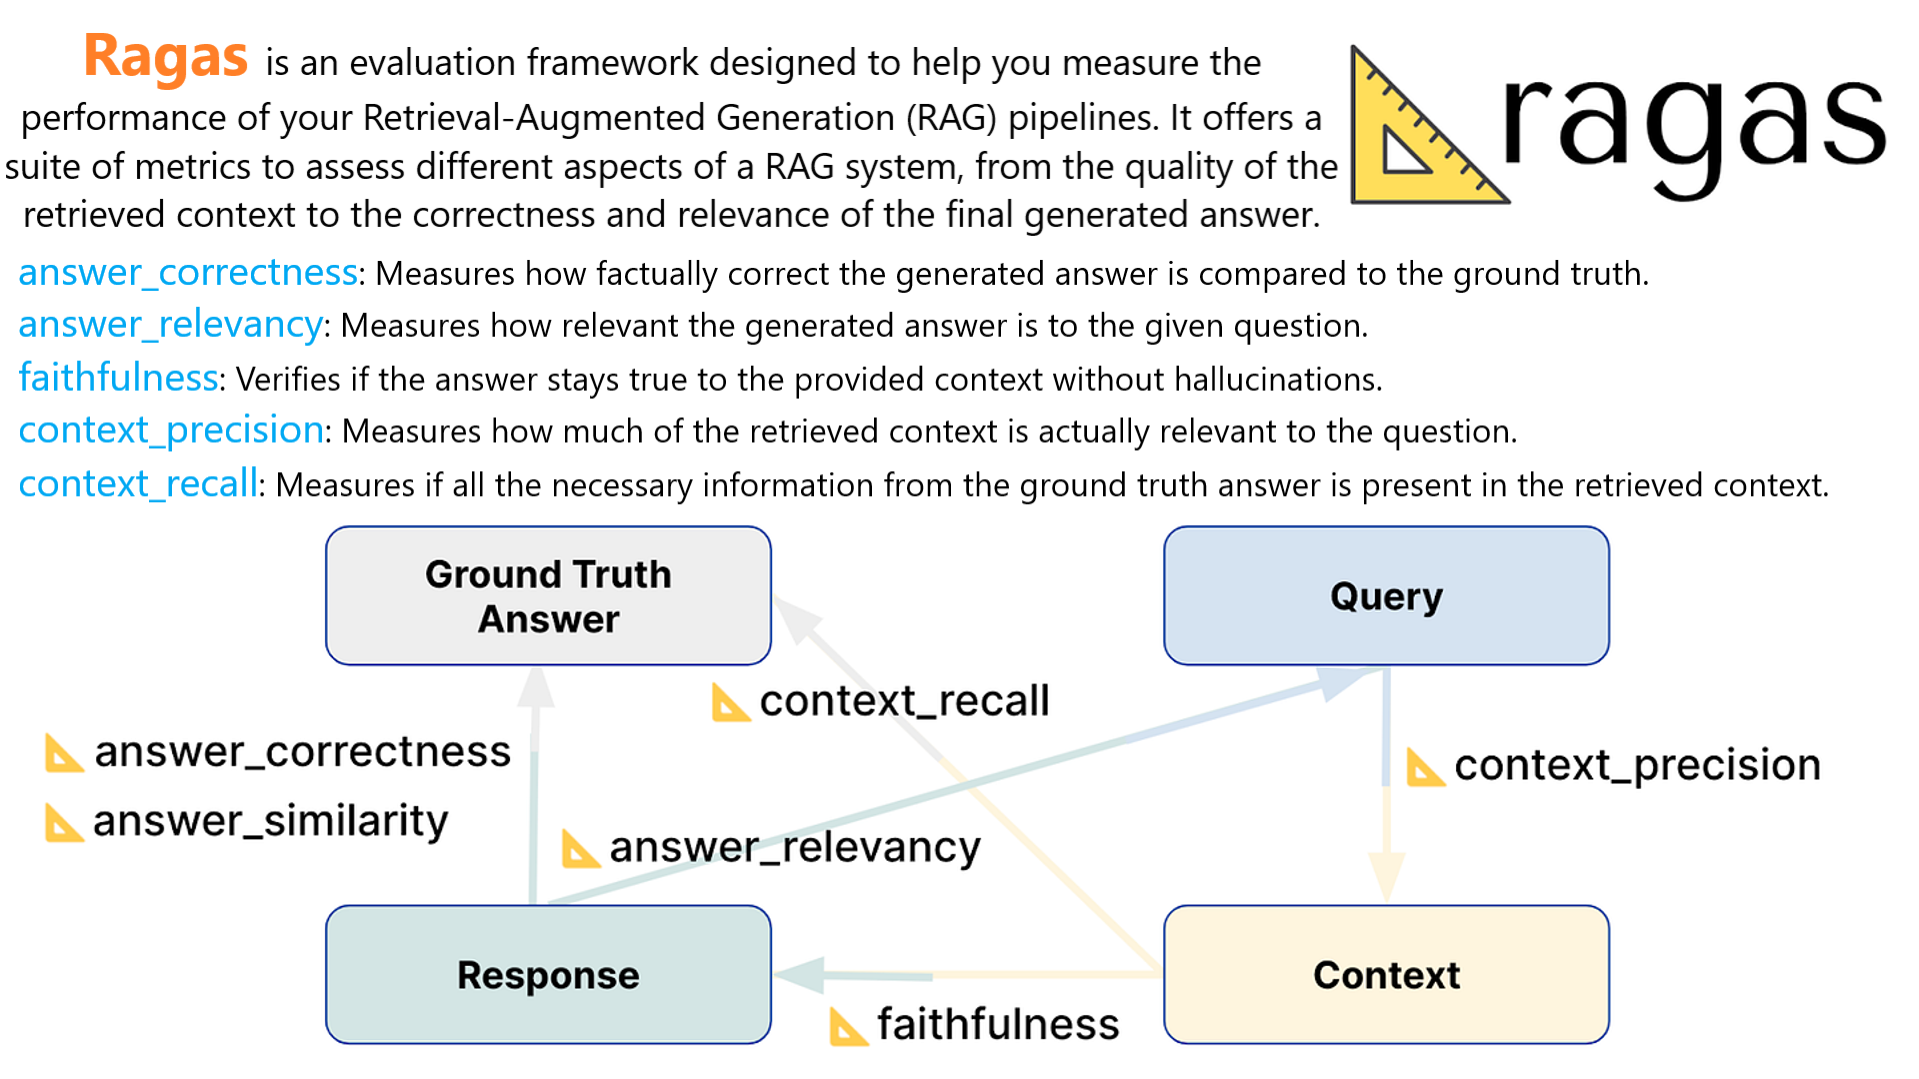

In [ ]:
# --- Configure Ragas ---
# Use the OpenAI model from OpenRouter as the judge
ragas_judge_llm = ChatOpenAI(model="openai/gpt-4o-mini")
# Use OpenAI embeddings for metrics that require them
ragas_embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-small-en-v1.5")

metrics_to_evaluate = [
    faithfulness,       # How factually consistent is the answer with the context?
    answer_correctness, # Measures how factually correct the generated answer is compared to the ground truth
    answer_relevancy,   # How relevant is the answer to the question?
    context_precision,  # Are the retrieved contexts relevant?
    context_recall,     # Were all necessary contexts retrieved?
]

In [ ]:
# --- Run Evaluation for Fine-Tuned Model ---
print("\n🚀 Evaluating Fine-Tuned Model...")
finetuned_ragas_result = evaluate(
    dataset=finetuned_dataset,
    metrics=metrics_to_evaluate,
    llm=ragas_judge_llm,
    embeddings=ragas_embeddings,
)
finetuned_df = finetuned_ragas_result.to_pandas()


🚀 Evaluating Fine-Tuned Model...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
print("\n--- Fine-Tuned Model Ragas Results ---")
finetuned_df[finetuned_df.columns[4:]]


--- Fine-Tuned Model Ragas Results ---


,faithfulness,answer_correctness,answer_relevancy,context_precision,context_recall
0,0.875,0.510287,0.996065,1.0,0.000000
1,1.000,0.466849,0.970119,1.0,0.000000
2,1.000,0.207397,0.927758,1.0,0.000000
3,0.800,0.260961,0.945448,1.0,0.666667
4,1.000,0.976988,1.000000,1.0,1.000000
5,1.000,0.846043,0.973946,1.0,1.000000


In [ ]:
# --- Run Evaluation for Base Model ---
print("\n🚀 Evaluating Base Model...")
base_ragas_result = evaluate(
    dataset=base_dataset,
    metrics=metrics_to_evaluate,
    llm=ragas_judge_llm,
    embeddings=ragas_embeddings,
)
base_df = base_ragas_result.to_pandas()


🚀 Evaluating Base Model...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
print("\n--- Base Model Ragas Results ---")
base_df[base_df.columns[4:]]


--- Base Model Ragas Results ---


,faithfulness,answer_correctness,answer_relevancy,context_precision,context_recall
0,0.840000,0.307115,0.996065,0.5,0.000000
1,1.000000,0.716625,0.970119,1.0,0.000000
2,0.785714,0.493616,0.927758,1.0,0.000000
3,0.772727,0.257640,0.945448,1.0,0.666667
4,1.000000,0.976988,1.000000,1.0,1.000000
5,0.444444,0.794797,0.973946,1.0,1.000000


#### ==============================================================================
# STEP 9: FINAL COMPARISON AND ANALYSIS
#### ==============================================================================
#### This final step provides a clear, high-level summary of the evaluation.
#### We compare the average scores of the base and fine-tuned models to
#### quantify the improvement achieved through fine-tuning.

In [ ]:
# Calculate average scores
avg_finetuned_scores = finetuned_df.mean(numeric_only=True)
avg_base_scores = base_df.mean(numeric_only=True)

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    "Fine-Tuned Model": avg_finetuned_scores,
    "Base Model": avg_base_scores
})
comparison_df['Improvement (%)'] = ((comparison_df['Fine-Tuned Model'] - comparison_df['Base Model']) / comparison_df['Base Model']) * 100


In [ ]:
print("\n\n" + "="*50)
print("📊 FINAL RAG PIPELINE EVALUATION SUMMARY")
print("="*50)
print("\nThis table shows the average score for each Ragas metric and the")
print("percentage improvement gained from fine-tuning the Phi-3 model.\n")
print(comparison_df.round(5))
print("\n" + "="*50)



📊 FINAL RAG PIPELINE EVALUATION SUMMARY

This table shows the average score for each Ragas metric and the
percentage improvement gained from fine-tuning the Phi-3 model.

                    Fine-Tuned Model  Base Model  Improvement (%)
faithfulness                 0.94583     0.80715         17.18219
answer_correctness           0.54475     0.59113         -7.84534
answer_relevancy             0.96889     0.96889          0.00000
context_precision            1.00000     0.91667          9.09091
context_recall               0.44444     0.44444          0.00000

